# CS5670 Project 5 - MNIST Challenge Notebook

Welcome to the Project 5 4-credit MNIST Challenge.

In this notebook you will create and train your own neural network model in PyTorch for classifying handwritten digits on the MNIST dataset.
We will pretend that we are targeting low-power and low-memory devices, and so you will have to limit the number of model parameters that you use.

## Installation of Dependencies

First you want to **make sure that you're using the GPU backend**.

* Go to Runtime -> Change runtime type and choose "GPU" under Hardware Accelerator.
* Only then run the next cell. It should print "GPU Support: True"

In [1]:
# http://pytorch.org/
from os import path
#!pip install pillow==7.1.2
#!python --version
import torch
print(torch. __version__)
import torchvision
print(torchvision. __version__)
print(f"GPU Support: {torch.cuda.is_available()}")

1.13.0
0.14.0
GPU Support: True


## Useful functions

Run the below cell to define functions that will be used later

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable

import urllib
import cv2
import numpy as np
import os, sys,  math, random, subprocess
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from IPython.display import clear_output, Image, display, HTML
from google.protobuf import text_format
from io import StringIO
import PIL.Image

def get_n_params(module):
  nparam = 0
  for name, param in module.named_parameters():
    param_count = 1
    for size in list(param.size()):
      param_count *= size
    nparam += param_count
  return nparam

def get_model_params(model):
  nparam = 0
  for name, module in model.named_modules():
    nparam += get_n_params(module)
  return nparam

def to_numpy_image(tensor_or_variable):
  
  # If this is already a numpy image, just return it
  if type(tensor_or_variable) == np.ndarray:
    return tensor_or_variable
  
  # Make sure this is a tensor and not a variable
  if type(tensor_or_variable) == Variable:
    tensor = tensor_or_variable.data
  else:
    tensor = tensor_or_variable
  
  # Convert to numpy and move to CPU if necessary
  np_img = tensor.cpu().numpy()
  
  # If there is no batch dimension, add one
  if len(np_img.shape) == 3:
    np_img = np_img[np.newaxis, ...]
  
  # Convert from BxCxHxW (PyTorch convention) to BxHxWxC (OpenCV/numpy convention)
  np_img = np_img.transpose(0, 2, 3, 1)
  
  return np_img

def normalize_zero_one_range(tensor_like):
  x = tensor_like - tensor_like.min()
  x = x / (x.max() + 1e-9)
  return x

def prep_for_showing(image):
  np_img = to_numpy_image(image)
  if len(np_img.shape) > 3:
    np_img = np_img[0]
  np_img = normalize_zero_one_range(np_img)
  return np_img

def show_image(tensor_var_or_np, title=None, bordercolor=None):
  np_img = prep_for_showing(tensor_var_or_np)
  
  if bordercolor is not None:
    np_img = draw_border(np_img, bordercolor)
  
  # plot it
  np_img = np_img.squeeze()
  plt.figure(figsize=(4,4))
  plt.imshow(np_img)
  plt.axis('off')
  if title: plt.title(title)
  plt.show()

## Training Data

We will use the [MNIST handrwritten digit dataset](http://yann.lecun.com/exdb/mnist/) to train our neural network models. There is a simple wrapper for the MNIST dataset in the torchvision package that implements the Dataset class. We will use that in conjunction with the DataLoader to load training data. Run the below cell to download and initialize our training and test datasets. You should see an example batch of images and their labels shown.

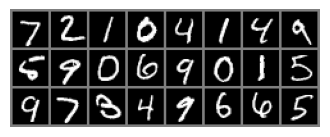

GroundTruth:  tensor(7) tensor(2) tensor(1) tensor(0) tensor(4) tensor(1) tensor(4) tensor(9) tensor(5) tensor(9) tensor(0) tensor(6) tensor(9) tensor(0) tensor(1) tensor(5) tensor(9) tensor(7) tensor(3) tensor(4) tensor(9) tensor(6) tensor(6) tensor(5)


In [8]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 24

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
show_image(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(BATCH_SIZE)))

## Model Definition (Example Model)

This is an example model provided to you. It is pretty good and it reaches >98% accuracy on the test set, but we can do better. In particular, we will try to break the 99% accuracy barrier with a tight limit on the number of model parameters.

In [9]:
class ExampleModel(nn.Module):
    def __init__(self):
        super(ExampleModel, self).__init__()
        # Convolution. Input channels: 1, output channels: 6, kernel size: 5
        self.conv1 = nn.Conv2d(1, 6, 5)
        # Max-pooling layer that will halve the HxW resolution
        self.pool = nn.MaxPool2d(2, 2)
        # Another 5x5 convolution that brings channel count up to 16
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Three fully connected layers
        self.fc1 = nn.Linear(16 * 4 * 4, 60)
        self.fc2 = nn.Linear(60, 40)
        self.fc3 = nn.Linear(40, 10)

    def forward(self, x):
        # Apply convolution, activation and pooling
        # Output width after convolution = (input_width - (kernel_size - 1) / 2)
        # Output width after pooling = input_width / 2
        
        # x.size() = Bx1x28x28
        x = self.pool(F.relu(self.conv1(x)))
        # x.size() = Bx6x12x12
        x = self.pool(F.relu(self.conv2(x)))
        # x.size() = Bx16x4x4
        
        # Flatten the output
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = ExampleModel()

nparams = get_n_params(net)
print(f"Model number of parameters: {nparams}")

Model number of parameters: 20842


## Model Definition (Your Model)

Define your own model here. It should satisfy the following constraints:
<font color="red">
*** Number of total model parameters: < 50000**
<br/>
*** Reaches test-set accuracy greater than or equal to 99% after training for 10 epochs**
</font>
  
A couple of ideas you can try:
* Different model structure (e.g. more layers, smaller/bigger kernels)
* Residual connections
* Batch [2] / Layer Normalization [3]
* Densely connected architectures [1]

<font size="1em">[1] Huang, G., Liu, Z., Weinberger, K. Q., & van der Maaten, L. (2017, July). Densely connected convolutional networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (Vol. 1, No. 2, p. 3).</font>
</br>
<font size="1em">[2] Ioffe, S., & Szegedy, C. (2015). Batch normalization: Accelerating deep network training by reducing internal covariate shift. arXiv preprint arXiv:1502.03167.</font>
</br>
<font size="1em">[3] Ba, J. L., Kiros, J. R., & Hinton, G. E. (2016). Layer normalization. arXiv preprint arXiv:1607.06450.
</font>

In [10]:
def autopad(k, p=None, d=1):  # kernel, padding, dilation
    # Pad to 'same' shape outputs
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k, int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

def _make_divisible(v, divisor, min_value=None):
    """
    This function ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class Conv(nn.Module):
    # Standard convolution with args(ch_in, ch_out, kernel, stride, padding, groups, dilation, activation)
    default_act = nn.Mish()

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        return self.act(self.conv(x))
    
class SELayer(nn.Module):
    def __init__(self, inp, oup, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(oup, _make_divisible(inp // reduction, 8)),
                nn.Mish(),
                nn.Linear(_make_divisible(inp // reduction, 8), oup),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y
    
class InvertedResidual(nn.Module):
    def __init__(self, c1, c2, stride=1, k_size_hidden=3, expand_ratio=2, use_se=False):
        super(InvertedResidual, self).__init__()
        hidden_dim = c1*expand_ratio
        self.identity = stride == 1 and c1 == c2
        self.conv_bn_act1 = Conv(c1, hidden_dim, k=1, s=1)
        self.dw_conv_bn_act1 = Conv(hidden_dim, hidden_dim, k=k_size_hidden, s=stride, p=stride, g=hidden_dim)
        self.se_layer = SELayer(c1, hidden_dim) if use_se else nn.Identity()
        self.conv3 = nn.Conv2d(hidden_dim, c2, 1, 1, 0,bias=False)
        self.bn3 = nn.BatchNorm2d(c2)
        
    def forward(self, x):
        inp = x
        x = self.conv_bn_act1(x)
        x = self.dw_conv_bn_act1(x)
        x = self.se_layer(x)
        x = self.conv3(x)
        x = self.bn3(x)
        return inp + x if self.identity else x

class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        # Define your modules here
        self.conv_bn_act1 = Conv(1, 16, k=3, s=1)  
        self.inverted_residual1 = InvertedResidual(16, 32, stride=2)
        self.inverted_residual2 = InvertedResidual(32, 32)
        self.inverted_residual3 = InvertedResidual(32, 32)
        self.inverted_residual4 = InvertedResidual(32, 32, use_se=True)
        self.inverted_residual5 = InvertedResidual(32, 64, stride=2, use_se=True)
        self.inverted_residual6 = InvertedResidual(64, 64, use_se=True)
        self.adaptive_avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(64,10)
        
    def forward(self, x):
        # Define your dynamic computational graph here
        x = self.conv_bn_act1(x)
        x = self.inverted_residual1(x)
        x = self.inverted_residual2(x)
        x = self.inverted_residual3(x)
        x = self.inverted_residual4(x)
        x = self.inverted_residual5(x)
        x = self.inverted_residual6(x)
        x = self.adaptive_avg_pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


net = StudentModel()

nparams = get_n_params(net)
print(f"Model number of parameters: {nparams}")

assert nparams < 50000, "Too many model parameters!"

Model number of parameters: 49530


## Training Loop

Run the following training loop to train your model. **Uncomment the line `net = StudentModel()` to use your model instead of the example model**.

In [11]:
import torch.optim as optim
PRINT_EVERY = 100

#-----------------------------------------------------------------------------
# Comment this line:
#net = ExampleModel()

# Uncomment this line
net = StudentModel()
#-----------------------------------------------------------------------------

if type(net) == ExampleModel:
  print("WARNING! Running example model. Uncomment line to run your own model!")

#-----------------------------------------------------------------------------

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
  net = net.cuda()
  print("Using GPU")
else:
  print("Not using GPU")
  
net.train()
  
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        if USE_CUDA:
          inputs = inputs.cuda()
          labels = labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data
        if i % PRINT_EVERY == PRINT_EVERY - 1:    # print every PRINT_EVERY mini-batches
            #show_image(torchvision.utils.make_grid(inputs.data))
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

Using GPU
[1,   100] loss: 2.260
[1,   200] loss: 2.057
[1,   300] loss: 1.865
[1,   400] loss: 1.695
[1,   500] loss: 1.514
[1,   600] loss: 1.298
[1,   700] loss: 1.119
[1,   800] loss: 0.968
[1,   900] loss: 0.808
[1,  1000] loss: 0.704
[1,  1100] loss: 0.654
[1,  1200] loss: 0.582
[1,  1300] loss: 0.506
[1,  1400] loss: 0.467
[1,  1500] loss: 0.421
[1,  1600] loss: 0.393
[1,  1700] loss: 0.338
[1,  1800] loss: 0.344
[1,  1900] loss: 0.325
[1,  2000] loss: 0.263
[1,  2100] loss: 0.251
[1,  2200] loss: 0.260
[1,  2300] loss: 0.229
[1,  2400] loss: 0.226
[1,  2500] loss: 0.213
[2,   100] loss: 0.222
[2,   200] loss: 0.193
[2,   300] loss: 0.177
[2,   400] loss: 0.194
[2,   500] loss: 0.183
[2,   600] loss: 0.175
[2,   700] loss: 0.164
[2,   800] loss: 0.170
[2,   900] loss: 0.161
[2,  1000] loss: 0.159
[2,  1100] loss: 0.172
[2,  1200] loss: 0.171
[2,  1300] loss: 0.128
[2,  1400] loss: 0.134
[2,  1500] loss: 0.135
[2,  1600] loss: 0.132
[2,  1700] loss: 0.133
[2,  1800] loss: 0.132
[

## Testing

Use the below cell to test your model on the MNIST test set. By right you should only run your model on the test set once, before publishing your results. In this assignment, we will allow you to re-use the test set, which is technically an incorrect practice.

In [12]:
correct = 0
total = 0

net.eval()

for data in testloader:
    images, labels = data
    images = Variable(images, volatile=True)
    if USE_CUDA:
      images, labels = images.cuda(), labels.cuda()
    
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

acc = 100 * correct / total
    
print(f'Accuracy of the network on the 10000 test images: {acc}%')
print(f'Correct: {correct}/{total}')
print("")

from IPython.display import Markdown, display

if acc >= 99:
  print("Congratulations! You beat the 99% barrier!")
else:
  print("Sorry, but you can do better. Try again!")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of the network on the 10000 test images: 99.08999633789062%
Correct: 9909/10000

Congratulations! You beat the 99% barrier!


### Per-class accuracy

Run the below cell to see which digits your model is better at recognizing and which digits it gets confused by.

In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for data in testloader:
    images, labels = data
    images = Variable(images, volatile=True)
    if USE_CUDA:
      images, labels = images.cuda(), labels.cuda()
    
    outputs = net(images)
    
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of     0 : 98 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 96 %
Accuracy of     4 : 99 %
Accuracy of     5 : 98 %
Accuracy of     6 : 98 %
Accuracy of     7 : 98 %
Accuracy of     8 : 98 %
Accuracy of     9 : 99 %
